In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

import torch

from micrograd.draw_dot import draw_dot

In [2]:
class Value:

    def __init__(self,data, _children = (), _op = (), label = (), parent_grad = ()):
        self.data = data
        self._prev = set(_children)
            # _children will be a tuple but will be held as a set in the class _prev - just done for efficiency
        self._op = _op
        self.label = label

        #derivative
        self.grad = 0.0 # initialized at 0 - assume that value does not effect output at the start
        
        #backpop funciton
        self._backward = lambda: None

    def __repr__(self):
        #python interally uses this repr function to return this string when the object is called on its own
        return f"Value(data={self.data})"
    
    #need to define addition
    def __add__(self,other):
        #check if other is a value object and make it one if not
        other = other if isinstance(other, Value) else Value(other)

        #use special underscore emthods to define operators in pytho
        # e.g. if we od a + b, python will interally do a.__add__(b)
        out = Value(self.data + other.data, _children = (self,other), _op = "+" )#this operator works as it is operating on self.data which is jsut a python number rather than our value class, second part is feeding in the _children expression to the new value obejct
        
        # definint g the function that propgates the gradient
        def _backward():
            # we want to propogate outs.grad and change self.grad and other.grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * self.grad

            # #recursive call ?not implemented
            # self._backward()
            # other._backward()
        out._backward = _backward

        return out
    
    #same for multiplication
    def __mul__(self, other):
        #check if other is a value object and make it one if not
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self,other), "*") #this operator works as it is operating on self.data which is jsut a python number rather than our value class
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

            # #recursive calls - think abotu variable scope it makes ense
            # self._backward()
            # other._backward()
        out._backward = _backward
        
        return out

    def __neg__(self): #-self
        return self * -1

    def __sub__(self,other): #self - other
        return self + (-other) #saves us rewriting addition #wowowowo
    
    def __rsub__(self,other): #other - self reverse multiplication
        #this is a fallback - if __sub__ doesnt work - so python will then check if the second term has a rmul
        # this seems super ineficient but i guess that is the point
        return self - other

    def __rmul__(self,other): #other * self reverse multiplication
        #this is a fallback - if __mul__ doesnt work - so python will then check if the second term has a rmul
        # this seems super ineficient but i guess that is the point
        return self * other

    def __radd__(self,other): #other + self reverse addition
        #this is a fallback - if __add__ doesnt work - so python will then check if the second term has a rmul
        # this seems super ineficient but i guess that is the point (python is clever and nice but slow)
        return self + other  
    
    def __truediv__(self,other):
        #division is a special case of exponentiation x**k a/b = a * b**-1
        return self * other**-1


    def exp(self):
        # app exponentiation
        x = self.data
        out = Value(math.exp(x), (self,), "exp") #only 1 child

        def _backward():
            #same pointer trickery as before
            self.grad += out.grad * out.data

        out._backward = _backward

        return out

    def __pow__(self,k):
        #other must be a int/float for now
        #otherwise math wont work for  aspecific case ??? cant backprop to the k value - makes sense
        assert isinstance(k, (int,float))

        out = Value(self.data**k, (self,), "**{}".format(k))

        def _backward():
            #calculus baby x**k = k*x**(k-1)
            # remember out.grad is the reverse chain rule component
            self.grad += out.grad * k*((self.data)**(k-1))

        out._backward = _backward

        return out

    #defined activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh") #only 1 child

        def _backward():
            
            self.grad += out.grad * (1 - t**2)
            
        out._backward = _backward
        
        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        #actaul backprop function - builds topolical tree and applies _backward attribute on it
    
        # building a topological graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)       
                topo.append(v) #only adds itself after all the children are processed
        build_topo(self)

        #go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for node in reversed(topo):
            node._backward()


In [102]:
class Neuron:
    def __init__(self, nin):
        #nin = number of inputs
        #randomly initializes weights and bias
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] 
        self.b = Value(0)

    def __call__(self,x):
        #funciton() = funciton.__call__()

        #return output = activation(w dot x + b)
        #dot product is essentially pairwise multiplication
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self. b)  #zip combines 2 iterators and iterates over the tuples of hte 2 interators combined 
        #interesting that sum works on Value() objects, second argument = intiial value - for a bit of efficiency
        out = act.relu()

        return out
    
    def parameters(self):
        #written this way to match pytorch
        #pytorch has a .parameters on every since NN module which does this
        #one subtle difference - in pytorch this returns the parameters tensors
        # for us we return theparamter scalars (actually value objects)
        # ?torch.Tensor is the equivalent to our Value() class hmmmm?
        return self.w + [self.b]


class Layer:
    def __init__(self,nin,nout):
        #initialize "nout" neurons each with "nin" inputs
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        #return forward pass of all neurons in the layer
        #"independently evaluate them"
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs #THIS IS THE CONDITIONAL RETURN SYNTAX DON'T NEED 2 RETURNS
    
    def parameters(self):
        #layer is also a module so to match pytorch it will lhave parameters - every module has parameters

        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        #SHORTEN THIS TO......

        return [p for neuron in self.neurons for p in neuron.parameters()] #nested single list comprehension
 
class MLP:
    def __init__(self,nin,nouts):
        #nin = number of inputs - scalar
        #nout = list of number of neurons in each layer
        sz = [nin] + nouts #concatenante these 2 together
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] #itrate through creating multiple layers

    def __call__(self,x):
        #need to pass each output as an input into the next layer
        #simple as that
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        #same format as above
        return [p for layer in self.layers for p in layer.parameters()]


In [113]:
#initialize network and inputs and ygt
nn = MLP(3,[10,10,1])

#draw_dot(nn(x))

xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys = [1.0,0,0,1.0] #desired targets

In [114]:
epochs = 20
for k in range(epochs):
    #forward pass
    ypred = [ nn(x) for x in xs]
    loss = sum(((yout - ygt)**2 for yout, ygt in zip(ypred,ys)))

    # I WAS RIGHT - NEED TO ZERO_GRAD() before backward pass
    for p in nn.parameters():
        p.grad = 0.0

    #backward pass
    loss.backward()

    # update
    for p in nn.parameters():
        step_size = 0.01
        p.data += -step_size * p.grad

    #print results
    print(k,loss.data)

ypred

0 3.9770917010272115
1 2.5962719748629395
2 2.3178093935332833
3 2.149282640899342
4 2.0704921809977153
5 2.0213223296230494
6 2.0044184961072986
7 2.0008273219287016
8 2.0003663615679077
9 2.000090638569193
10 2.0000502811813563
11 2.0000124568077027
12 2.000005481895418
13 2.0000024119123045
14 2.0000005888537125
15 2.000000326511596
16 2.0000001435980357
17 2.0000000796237876
18 2.000000019423439
19 2.000000010770001


[Value(data=0),
 Value(data=0),
 Value(data=0.0001037786134989796),
 Value(data=0)]

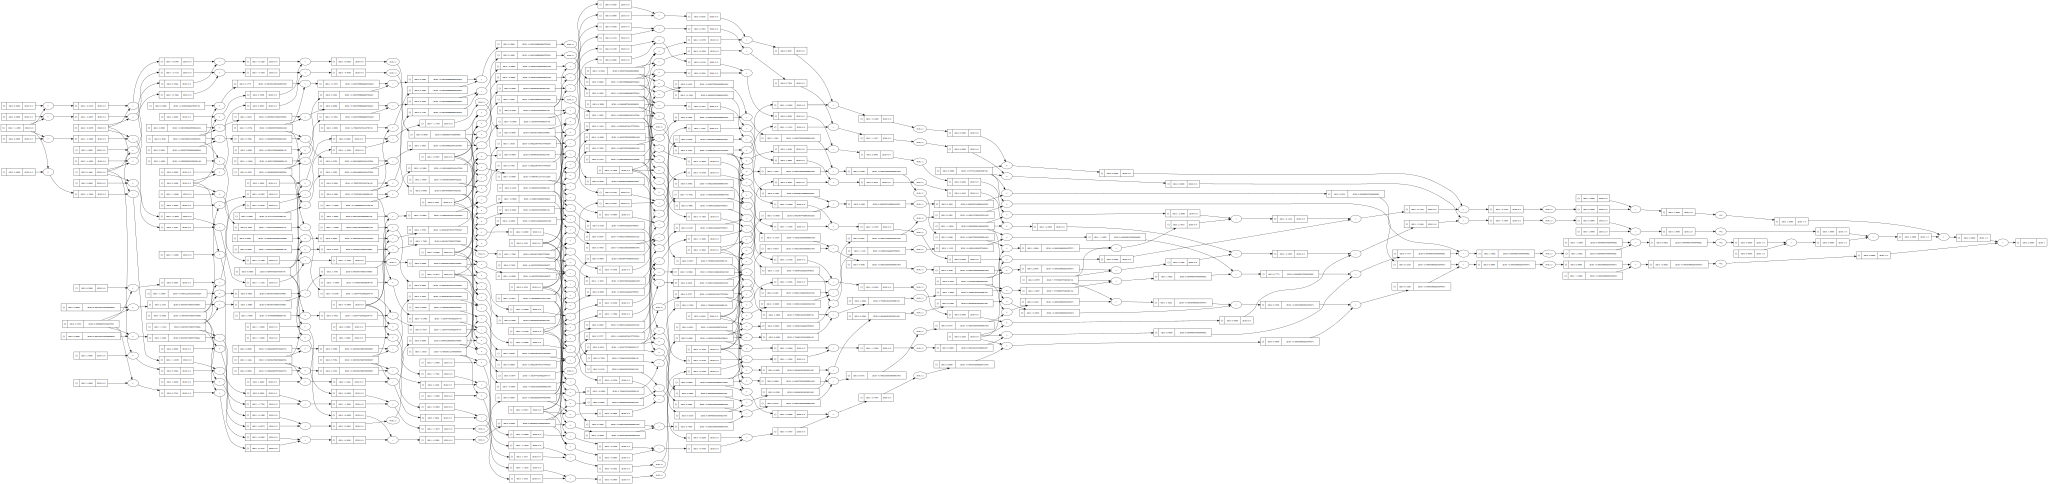

In [52]:
#draw_dot(loss)